In [1]:
from __future__ import print_function

import csv
import os

import numpy as np

import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import random

import models

from tqdm import tqdm_notebook as tqdm


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [2]:
args = {
    'model': 'ResNet18',
    'data': 'cifar10',
    'nclass': 10,
    'lr': 0.1,
    'batch_size': 128,
    'epoch': 50,
    'augment': False,
    'decay': 1e-4,
    'name': 'cross',
    'seed': 0,
    'resume': False,
    'klam': 4,
    'mode': 'instahide',
    'upper': 0.65,
}

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
criterion = nn.CrossEntropyLoss()
best_acc = 0  # best test accuracy
if args['seed'] != 0:
    torch.manual_seed(args['seed'])
    np.random.seed(args['seed'])

## Functions

In [4]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def label_to_onehot(target, num_classes=args['nclass']):
    '''Returns one-hot embeddings of scaler labels'''
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(
        0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target


def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))


def mixup_criterion(pred, ys, lam_batch, num_class=args['nclass']):
    '''Returns mixup loss'''
    ys_onehot = [label_to_onehot(y, num_classes=num_class) for y in ys]
    mixy = vec_mul_ten(lam_batch[:, 0], ys_onehot[0])
    for i in range(1, args['klam']):
        mixy += vec_mul_ten(lam_batch[:, i], ys_onehot[i])
    l = cross_entropy_for_onehot(pred, mixy)
    return l


def vec_mul_ten(vec, tensor):
    '''
        
    '''
    size = list(tensor.size())
    size[0] = -1
    size_rs = [1 for i in range(len(size))]
    size_rs[0] = -1
    vec = vec.reshape(size_rs).expand(size)
    res = vec * tensor
    return res


def mixup_data(x, y, use_cuda=True):
    '''Returns mixed inputs, lists of targets, and lambdas'''
    lams = np.random.normal(0, 1, size=(x.size()[0], args['klam']))
    for i in range(x.size()[0]):
        lams[i] = np.abs(lams[i]) / np.sum(np.abs(lams[i]))
        if args['klam'] > 1:
            while lams[i].max() > args['upper']:     # upper bounds a single lambda (or (lams[i][0] + lams[i][1]) < args['dom'])
                lams[i] = np.random.normal(0, 1, size=(1, args['klam']))
                lams[i] = np.abs(lams[i]) / np.sum(np.abs(lams[i]))

    lams = torch.from_numpy(lams).float().to(device)

    mixed_x = vec_mul_ten(lams[:, 0], x)
    ys = [y]

    for i in range(1, args['klam']):
        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(device)
        mixed_x  += vec_mul_ten(lams[:, i], x[index, :])
        ys.append(y[index])         # Only keep the labels for private samples

    if args['mode'] == 'instahide': # TODO -> from adding random flip mask, 
        sign = torch.randint(2, size=list(x.shape), device=device) * 2.0 - 1
        mixed_x *= sign.float().to(device)
    return mixed_x, ys, lams


def generate_sample(trainloader):
    assert len(trainloader) == 1        # Load all training data once
    
    for _, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)
        mix_inputs, mix_targets, lams = mixup_data(
            inputs, targets.float(), use_cuda)
    return (mix_inputs, mix_targets, inputs, targets, lams)

def prepare_data():
    ## --------------- Prepare data --------------- ##
    print('==> Preparing data..')

    cifar_normalize = transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    
    mnist_normalize = transforms.Normalize((0.1307,), (0.3081,))

    transform_imagenet = transforms.Compose([
        transforms.Resize(40),
        transforms.RandomCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    if args['augment']:
        transform_cifar_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            cifar_normalize
        ])
        
        transform_mnist_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            mnist_normalize
        ])
    else:
        transform_cifar_train = transforms.Compose([
            transforms.ToTensor(),
            cifar_normalize
        ])
        
        transform_mnist_train = transforms.Compose([
            transforms.ToTensor(),
            mnist_normalize
        ])

    transform_cifar_test = transforms.Compose([
        transforms.ToTensor(),
        cifar_normalize
    ])
    
    transform_mnist_test = transforms.Compose([
        transforms.ToTensor(),
        mnist_normalize
    ])

    if args['data'] == 'cifar10':
        trainset = datasets.CIFAR10(root='Dataset/CIFAR10',
                                    train=True,
                                    download=True,
                                    transform=transform_cifar_train)
        testset = datasets.CIFAR10(root='Dataset/CIFAR10',
                                   train=False,
                                   download=True,
                                   transform=transform_cifar_test)
        num_class = 10

    if args['data'] == 'mnist':
        trainset = datasets.MNIST(root='Dataset/MNIST', 
                                  train=True, 
                                  download=False, 
                                  transform=transform_mnist_train)

        testset = datasets.MNIST(root='Dataset/MNIST',
                               train=False,
                               download=False,
                               transform=transform_mnist_test)
        
    return trainset, testset

def plot_difference(orig, trans, idx=[23, 15]):
    f, ax = plt.subplots(2, 2, figsize=(14,14))    
    for i in range(2):
        ax[i][0].imshow(orig[idx[i]].transpose((1,2,0)))
        ax[i][1].imshow(trans[idx[i]].transpose((1,2,0)))
    plt.show()

In [5]:
trainset, testset = prepare_data()
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=len(trainset),
                                          shuffle=False,
                                          num_workers=8)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=args['batch_size'],
                                         shuffle=False,
                                         num_workers=8)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


### Run original mixup instahide

In [6]:
ckptname = './checkpoint/ResNet18_cifar10_mixup_4_cross_0.t7'

checkpoint = torch.load(ckptname)
net = checkpoint['net']
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch'] + 1
rng_state = checkpoint['rng_state']
torch.set_rng_state(rng_state)

In [7]:
net.cuda()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): PreActBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (shortcut): Sequential()
      )
      (1): PreActBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [8]:
args['klam'] = 4
print('==> Number of lambdas: %g' % args['klam'])
mix_inputs_lamb4, mix_targets_all, original_inputs, original_targets, lams = generate_sample(trainloader)

==> Number of lambdas: 4


In [9]:
mix_inputs_all = mix_inputs_lamb4.detach().cpu().numpy()
original_inputs_all = original_inputs.detach().cpu().numpy()
original_targets_ = original_targets.detach().cpu().numpy()

In [10]:
from custom_loss.l2m import L2M

lm = L2M(net, 10, max_iterations=1000, targeted=True, binary_search_steps=9)

In [11]:
for i in range(3, 10):
    print('%d th data' % i)
    perturbed = lm.perturb(original_inputs[5000*(i):5000*(i+1)], original_targets[5000*(i):5000*(i+1)])
    pert = perturbed.detach().cpu().numpy()

    np.save('results/perturbed_5000_%d_trial1.npy'%i, pert)
    np.save('results/y_5000_%d_trial1.npy'%i, original_targets_[5000*(i):5000*(i+1)])

3 th data
0 step loss: 11.0059
20 step loss: -20146.1504
40 step loss: -99755.6484
60 step loss: -246659.4531
80 step loss: -439240.3750
100 step loss: -640145.7500
120 step loss: -815000.6875
140 step loss: -945575.3750
160 step loss: -1034117.0625
180 step loss: -1094604.1250
200 step loss: -1136229.3750
220 step loss: -1163875.7500
240 step loss: -1182826.8750
260 step loss: -1196707.2500
280 step loss: -1207386.7500
300 step loss: -1215878.5000
320 step loss: -1222791.8750
340 step loss: -1228523.5000
360 step loss: -1233346.0000
380 step loss: -1237453.6250
400 step loss: -1240989.2500
420 step loss: -1244060.5000
440 step loss: -1246749.3750
460 step loss: -1249120.3750
480 step loss: -1251224.6250
500 step loss: -1253102.8750
520 step loss: -1254788.3750
540 step loss: -1256307.5000
560 step loss: -1257682.1250
580 step loss: -1258933.5000
600 step loss: -1260076.7500
620 step loss: -1261124.5000
640 step loss: -1262089.1250
660 step loss: -1262981.1250
680 step loss: -1263808.7

740 step loss: -1612214.2500
760 step loss: -1627899.3750
780 step loss: -1643041.0000
800 step loss: -1657548.2500
820 step loss: -1671492.3750
840 step loss: -1685061.5000
860 step loss: -1698093.1250
880 step loss: -1710548.7500
900 step loss: -1722418.5000
920 step loss: -1733924.6250
940 step loss: -1745117.1250
960 step loss: -1755909.0000
980 step loss: -1766230.5000
0 step loss: 85.6355
20 step loss: -20239.9258
40 step loss: -99992.0547
60 step loss: -246986.8906
80 step loss: -439614.4688
100 step loss: -640518.4375
120 step loss: -815305.5000
140 step loss: -945737.7500
160 step loss: -1034078.8750
180 step loss: -1094322.1250
200 step loss: -1135918.3750
220 step loss: -1163740.8750
240 step loss: -1182833.7500
260 step loss: -1196793.3750
280 step loss: -1207519.0000
300 step loss: -1216040.3750
320 step loss: -1222978.2500
340 step loss: -1228775.2500
360 step loss: -1233874.7500
380 step loss: -1238815.1250
400 step loss: -1244177.5000
420 step loss: -1250485.7500
440 st

480 step loss: -2644588.7500
500 step loss: -2747029.5000
520 step loss: -2837083.5000
540 step loss: -2918209.2500
560 step loss: -2992652.2500
580 step loss: -3061536.0000
600 step loss: -3124980.0000
620 step loss: -3183350.7500
640 step loss: -3236729.7500
660 step loss: -3285242.5000
680 step loss: -3329240.5000
700 step loss: -3368927.2500
720 step loss: -3404956.7500
740 step loss: -3437978.5000
760 step loss: -3468291.0000
780 step loss: -3496304.0000
800 step loss: -3522374.0000
820 step loss: -3546857.2500
840 step loss: -3569944.7500
860 step loss: -3591750.0000
880 step loss: -3612503.2500
900 step loss: -3632228.5000
920 step loss: -3651149.2500
940 step loss: -3669432.5000
960 step loss: -3687053.0000
980 step loss: -3704105.7500
0 step loss: 503.7122
20 step loss: -20256.0234
40 step loss: -99783.7734
60 step loss: -245795.8438
80 step loss: -436850.1250
100 step loss: -635897.3750
120 step loss: -808949.8125
140 step loss: -937953.5625
160 step loss: -1024883.8750
180 s

220 step loss: -1154679.0000
240 step loss: -1173582.2500
260 step loss: -1187407.5000
280 step loss: -1198034.5000
300 step loss: -1206479.1250
320 step loss: -1213352.5000
340 step loss: -1219064.2500
360 step loss: -1223953.1250
380 step loss: -1228366.6250
400 step loss: -1232663.0000
420 step loss: -1237226.0000
440 step loss: -1242328.3750
460 step loss: -1248149.2500
480 step loss: -1254826.7500
500 step loss: -1262275.8750
520 step loss: -1270416.5000
540 step loss: -1279109.7500
560 step loss: -1288140.8750
580 step loss: -1297304.8750
600 step loss: -1306515.2500
620 step loss: -1315760.7500
640 step loss: -1325044.6250
660 step loss: -1334276.3750
680 step loss: -1343494.3750
700 step loss: -1352562.8750
720 step loss: -1361429.0000
740 step loss: -1370184.1250
760 step loss: -1378916.2500
780 step loss: -1387486.2500
800 step loss: -1395934.0000
820 step loss: -1404195.5000
840 step loss: -1412266.8750
860 step loss: -1420277.0000
880 step loss: -1428238.1250
900 step loss:

960 step loss: -2179257.2500
980 step loss: -2191812.0000
0 step loss: 131.9755
20 step loss: -20192.0742
40 step loss: -99656.8203
60 step loss: -245992.5781
80 step loss: -437674.5625
100 step loss: -637610.0625
120 step loss: -811713.6250
140 step loss: -941790.3750
160 step loss: -1029924.3125
180 step loss: -1089987.2500
200 step loss: -1131535.8750
220 step loss: -1159459.1250
240 step loss: -1178641.5000
260 step loss: -1192658.2500
280 step loss: -1203421.2500
300 step loss: -1211966.1250
320 step loss: -1218964.0000
340 step loss: -1225142.2500
360 step loss: -1231728.7500
380 step loss: -1240300.1250
400 step loss: -1252142.0000
420 step loss: -1267682.3750
440 step loss: -1286578.5000
460 step loss: -1308274.5000
480 step loss: -1331897.1250
500 step loss: -1356415.8750
520 step loss: -1381054.1250
540 step loss: -1405208.6250
560 step loss: -1428544.3750
580 step loss: -1450874.0000
600 step loss: -1472207.7500
620 step loss: -1492651.7500
640 step loss: -1512401.3750
660 s

700 step loss: -4088326.7500
720 step loss: -4127912.5000
740 step loss: -4163842.2500
760 step loss: -4196737.0000
780 step loss: -4227084.5000
800 step loss: -4255423.5000
820 step loss: -4282083.0000
840 step loss: -4307154.5000
860 step loss: -4330812.0000
880 step loss: -4353187.5000
900 step loss: -4374593.0000
920 step loss: -4395001.5000
940 step loss: -4414486.0000
960 step loss: -4433295.0000
980 step loss: -4451423.0000
0 step loss: 977.6681
20 step loss: -20519.7949
40 step loss: -101346.3750
60 step loss: -249298.0938
80 step loss: -442567.4688
100 step loss: -643669.6875
120 step loss: -818365.1250
140 step loss: -948548.1250
160 step loss: -1036048.6250
180 step loss: -1094983.8750
200 step loss: -1136240.6250
220 step loss: -1165258.7500
240 step loss: -1185884.2500
260 step loss: -1201179.3750
280 step loss: -1213359.0000
300 step loss: -1227267.2500
320 step loss: -1266544.6250
340 step loss: -1374114.8750
360 step loss: -1553874.5000
380 step loss: -1770502.8750
400 

440 step loss: -1258028.0000
460 step loss: -1264098.5000
480 step loss: -1271036.3750
500 step loss: -1278754.6250
520 step loss: -1287184.3750
540 step loss: -1296178.2500
560 step loss: -1305553.1250
580 step loss: -1315147.8750
600 step loss: -1324913.5000
620 step loss: -1334640.8750
640 step loss: -1344291.5000
660 step loss: -1353833.5000
680 step loss: -1363225.1250
700 step loss: -1372515.0000
720 step loss: -1381721.2500
740 step loss: -1390718.1250
760 step loss: -1399465.6250
780 step loss: -1408169.3750
800 step loss: -1416740.1250
820 step loss: -1425152.6250
840 step loss: -1433486.8750
860 step loss: -1441779.6250
880 step loss: -1449909.6250
900 step loss: -1457772.6250
920 step loss: -1465481.7500
940 step loss: -1472996.0000
960 step loss: -1480264.5000
980 step loss: -1487426.8750
0 step loss: 67.4532
20 step loss: -20361.5371
40 step loss: -100607.1484
60 step loss: -248436.8125
80 step loss: -441969.5000
100 step loss: -643636.5625
120 step loss: -819040.9375
140 

180 step loss: -1116784.0000
200 step loss: -1159116.5000
220 step loss: -1187921.1250
240 step loss: -1207847.8750
260 step loss: -1222420.1250
280 step loss: -1233603.0000
300 step loss: -1242546.1250
320 step loss: -1250536.2500
340 step loss: -1260840.6250
360 step loss: -1278637.6250
380 step loss: -1307347.8750
400 step loss: -1346938.1250
420 step loss: -1395095.1250
440 step loss: -1448438.6250
460 step loss: -1503464.8750
480 step loss: -1557410.8750
500 step loss: -1608520.3750
520 step loss: -1656043.8750
540 step loss: -1699991.3750
560 step loss: -1740495.2500
580 step loss: -1778036.0000
600 step loss: -1813039.7500
620 step loss: -1845842.7500
640 step loss: -1876703.1250
660 step loss: -1905828.8750
680 step loss: -1933478.0000
700 step loss: -1959582.1250
720 step loss: -1984307.1250
740 step loss: -2007645.0000
760 step loss: -2029640.7500
780 step loss: -2050293.5000
800 step loss: -2069651.7500
820 step loss: -2087977.7500
840 step loss: -2105338.5000
860 step loss:

900 step loss: -1266128.7500
920 step loss: -1266621.7500
940 step loss: -1267106.7500
960 step loss: -1267596.2500
980 step loss: -1268079.2500
0 step loss: 1891.0996
20 step loss: -19911.1699
40 step loss: -99778.5234
60 step loss: -245921.7031
80 step loss: -437086.5938
100 step loss: -636270.2500
120 step loss: -809548.9375
140 step loss: -938985.6250
160 step loss: -1025968.3125
180 step loss: -1084246.1250
200 step loss: -1125103.1250
220 step loss: -1154280.1250
240 step loss: -1175367.7500
260 step loss: -1191281.1250
280 step loss: -1204956.6250
300 step loss: -1229395.1250
320 step loss: -1325354.8750
340 step loss: -1560779.3750
360 step loss: -1890005.1250
380 step loss: -2228013.5000
400 step loss: -2525535.0000
420 step loss: -2768120.7500
440 step loss: -2959696.7500
460 step loss: -3111808.0000
480 step loss: -3236774.2500
500 step loss: -3344356.0000
520 step loss: -3440872.0000
540 step loss: -3529875.0000
560 step loss: -3613049.2500
580 step loss: -3691146.5000
600 

640 step loss: -1363678.3750
660 step loss: -1375136.7500
680 step loss: -1386364.3750
700 step loss: -1397356.7500
720 step loss: -1408118.8750
740 step loss: -1418680.0000
760 step loss: -1429003.6250
780 step loss: -1439121.0000
800 step loss: -1448881.1250
820 step loss: -1458470.6250
840 step loss: -1467907.3750
860 step loss: -1477116.8750
880 step loss: -1486153.2500
900 step loss: -1494940.7500
920 step loss: -1503491.0000
940 step loss: -1511840.0000
960 step loss: -1520000.7500
980 step loss: -1527912.5000
0 step loss: 69.8193
20 step loss: -20125.7715
40 step loss: -99472.2031
60 step loss: -245796.6562
80 step loss: -437655.6562
100 step loss: -637874.6250
120 step loss: -812182.5625
140 step loss: -942318.8125
160 step loss: -1030443.3125
180 step loss: -1090530.5000
200 step loss: -1132003.6250
220 step loss: -1159698.2500
240 step loss: -1178692.3750
260 step loss: -1192583.1250
280 step loss: -1203256.6250
300 step loss: -1211736.6250
320 step loss: -1218638.6250
340 st

380 step loss: -1450876.0000
400 step loss: -1568777.7500
420 step loss: -1691685.7500
440 step loss: -1809514.1250
460 step loss: -1916694.7500
480 step loss: -2011420.5000
500 step loss: -2094523.2500
520 step loss: -2168193.0000
540 step loss: -2234197.0000
560 step loss: -2294418.2500
580 step loss: -2350110.0000
600 step loss: -2401710.2500
620 step loss: -2449561.5000
640 step loss: -2493760.0000
660 step loss: -2534564.5000
680 step loss: -2572068.0000
700 step loss: -2606551.5000
720 step loss: -2638322.0000
740 step loss: -2667657.7500
760 step loss: -2694723.0000
780 step loss: -2719739.7500
800 step loss: -2743029.0000
820 step loss: -2764681.7500
840 step loss: -2785036.2500
860 step loss: -2804331.5000
880 step loss: -2822656.5000
900 step loss: -2840101.7500
920 step loss: -2856695.7500
940 step loss: -2872572.2500
960 step loss: -2887937.7500
980 step loss: -2902749.0000
0 step loss: 253.6434
20 step loss: -20546.4531
40 step loss: -101242.3672
60 step loss: -249627.0312

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


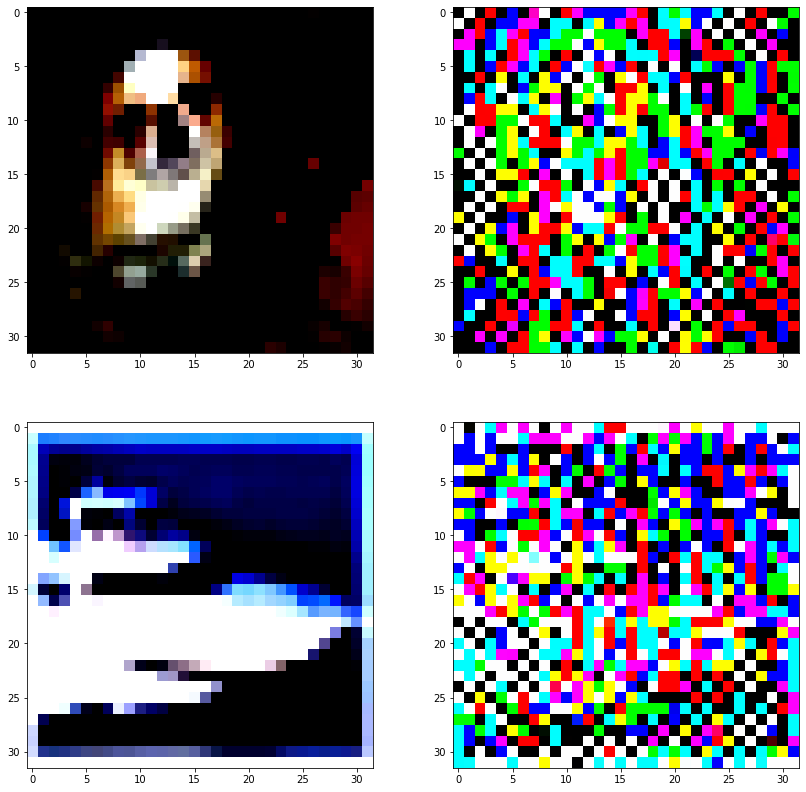

In [17]:
plot_difference(original_inputs_all[5000*9:], pert, [18,25])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


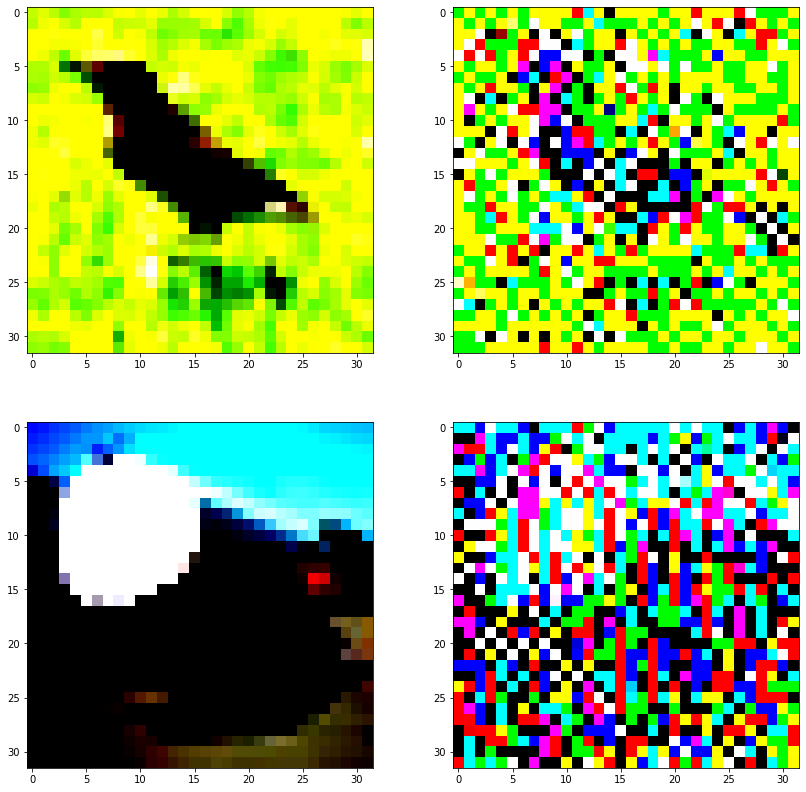

In [13]:
plot_difference(original_inputs_all[5000*9:], pert, [21,44])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


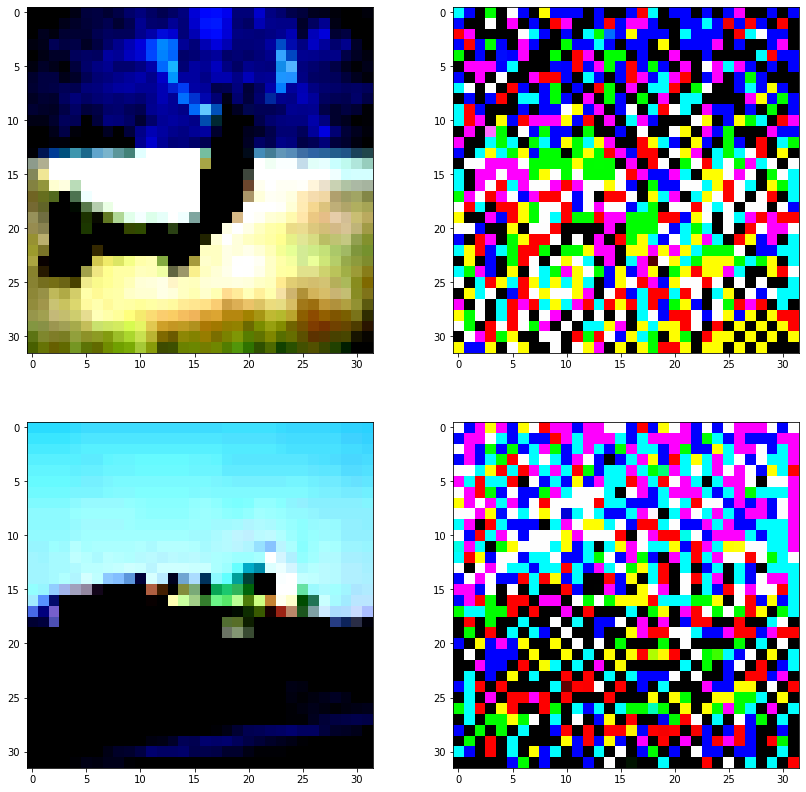

In [14]:
plot_difference(original_inputs_all[5000*9:], pert, [121,386])